# Introduction to Hidden Markov Models

## Prerequisites

* Markov Chains and Markovian Processes
* Probability and Bayes' Theorem
* Linear Algebra

## Learning Goals

* Approximate Reality: transform a basic question with possible business value into a simple supervised learning problem (w/ label noise),
* Create a baseline model to check the "fidelity" of the proxy to reality,
* Build a Hidden Markov Model using `seqlearn` and/or `hmmlearn`.

## Imports

In [1]:
# The original version of seqlearn has scipy dependencies which are out of date.
# !pip install -U git+https://github.com/PureMath86/seqlearn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

import yfinance as yf

from scipy.signal import savgol_filter, argrelmin, argrelmax

from seqlearn.hmm import MultinomialHMM
from hmmlearn.hmm import GaussianHMM as HMM

from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\purem\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Get Stock Data

In [3]:
asset = yf.Ticker("AGRX")

# get historical market data
hist = asset.history(period="24mo")

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-31,3.30,3.35,3.240,3.28,134000,0,0
2018-02-01,3.27,3.33,3.221,3.26,87700,0,0
2018-02-02,3.23,3.32,3.220,3.27,121000,0,0
2018-02-05,3.26,3.31,3.141,3.19,185200,0,0
2018-02-06,3.14,3.30,3.010,3.25,189400,0,0


## Visualize

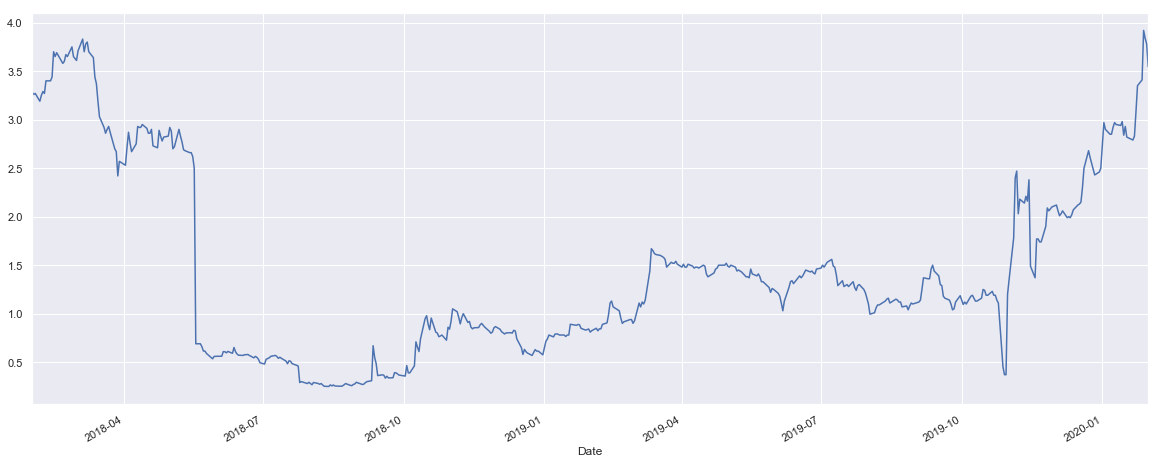

In [5]:
plt.figure(figsize=(20,8))
hist.Close.plot()
plt.show()

## Smooth

In [6]:
window = 15
hist['smooth'] = savgol_filter(hist.Close, 2*window+1, polyorder=3)
hist['smooth'] = savgol_filter(hist.smooth, 2*window+1, polyorder=1)
hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=3)
hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=1)

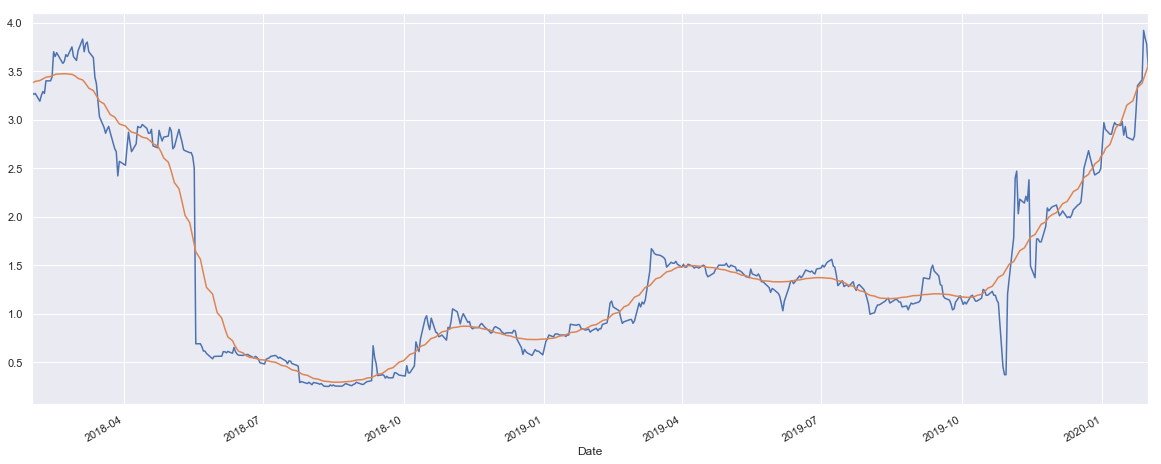

In [7]:
plt.figure(figsize=(20,8))
hist.Close.plot()
hist.smooth.plot()
plt.show()

## Create a Target : "Near" Local Minima / Breakout Points

In [8]:
target = 'target'
hist[target] = 0

min_ids = argrelmin(hist.smooth.values)[0].tolist()
max_ids = argrelmax(hist.smooth.values)[0].tolist()

hist[target].iloc[min_ids] = 1
hist[target].iloc[max_ids] = -1

hist[target] = hist[target].replace(0, np.nan).interpolate(method='slinear').fillna(0)
hist[target] = (hist[target] > 0.8).astype(np.int)

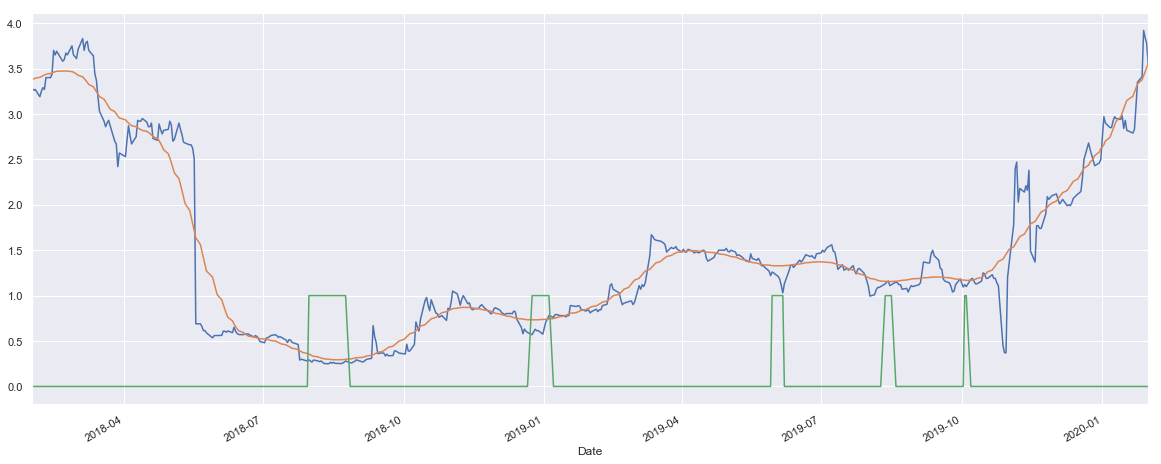

In [9]:
plt.figure(figsize=(20,8))
hist.Close.plot()
hist.smooth.plot()
hist.target.plot()
plt.show()

## Feature Engineering

In [10]:
data = hist[['Close', 'Open', 'Low', 'High']]
data.head()

,Close,Open,Low,High
Date,,,,
2018-01-31,3.28,3.30,3.240,3.35
2018-02-01,3.26,3.27,3.221,3.33
2018-02-02,3.27,3.23,3.220,3.32
2018-02-05,3.19,3.26,3.141,3.31
2018-02-06,3.25,3.14,3.010,3.30


In [11]:
windows = [3, 5, 10, 15, 20, 30, 45, 60]

for i in windows:
    ma = data.Close.rolling(i).mean()
    data['MACD_'+str(i)] = ma - data.Close
    data['PctDiff_'+str(i)] = data.Close.diff(i)
    data['StdDev_'+str(i)] = data.Close.rolling(i).std()

factor = data.Close.copy()
for c in data.columns.tolist():
    data[c] = data[c] / factor
    
data[target] = hist[target]
data = data.dropna()
del data['Close']

used_cols = [c for c in data.columns.tolist() if c not in [target]]
data.head()

,Open,Low,High,MACD_3,PctDiff_3,StdDev_3,MACD_5,PctDiff_5,StdDev_5,MACD_10,...,MACD_30,PctDiff_30,StdDev_30,MACD_45,PctDiff_45,StdDev_45,MACD_60,PctDiff_60,StdDev_60,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-27,0.989362,0.982270,1.010638,-0.003546,-0.024823,0.009382,-4.964539e-03,0.031915,0.023602,0.003191,...,-0.005083,-0.131206,0.048974,0.092356,-0.301418,0.149007,0.124586,-0.163121,0.144099,0
2018-04-30,1.003534,0.982332,1.021201,-0.007067,0.000000,0.009349,-1.569220e-16,0.042403,0.013912,-0.003180,...,-0.010954,-0.070671,0.046494,0.082057,-0.289753,0.145813,0.118080,-0.151943,0.144365,0
2018-05-01,0.965753,0.965753,1.010274,-0.021689,0.047945,0.018862,-2.876712e-02,0.010274,0.017563,-0.031849,...,-0.041438,0.000000,0.045061,0.042390,-0.284247,0.136833,0.081621,-0.119863,0.140245,0
2018-05-02,1.010417,1.000000,1.038194,-0.001157,0.020833,0.015657,-1.180556e-02,0.017361,0.018955,-0.017708,...,-0.027894,0.006944,0.045815,0.050926,-0.267361,0.135194,0.094850,-0.107639,0.142730,0
2018-05-03,1.085185,0.970370,1.100000,0.049383,-0.048148,0.043403,4.814815e-02,-0.029630,0.030765,0.040370,...,0.034444,-0.074074,0.048799,0.113333,-0.344444,0.141186,0.164444,-0.203704,0.153696,0


## Baseline: Scorecard

In [12]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=5, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
pipe = make_pipeline(binner, objectify, encoder, clf)

X, y = data[used_cols].values, data.target.values
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

(0.8516859567901236, 0.05763566034969397)

## Transform Data

In [13]:
X = Pipeline(pipe.steps[:-1]).fit_transform(X, y).values

## Prep for HMM (in SeqLearn)

In [14]:
quot = 3
length = y.shape[0]
div = length//quot
remainder = length % quot
length == div*quot + remainder

True

In [15]:
remainder

0

In [16]:
lengths = [div]*quot #+ [remainder]
lengths

[148, 148, 148]

## Hidden Markov Model (w/ SeqLearn)

In [17]:
hmm = MultinomialHMM(alpha=1e4)
hmm.fit(X, y, lengths)

MultinomialHMM(alpha=10000.0, decode='viterbi')

In [18]:
preds = hmm.predict(X, lengths)

In [19]:
data['pred'] = preds

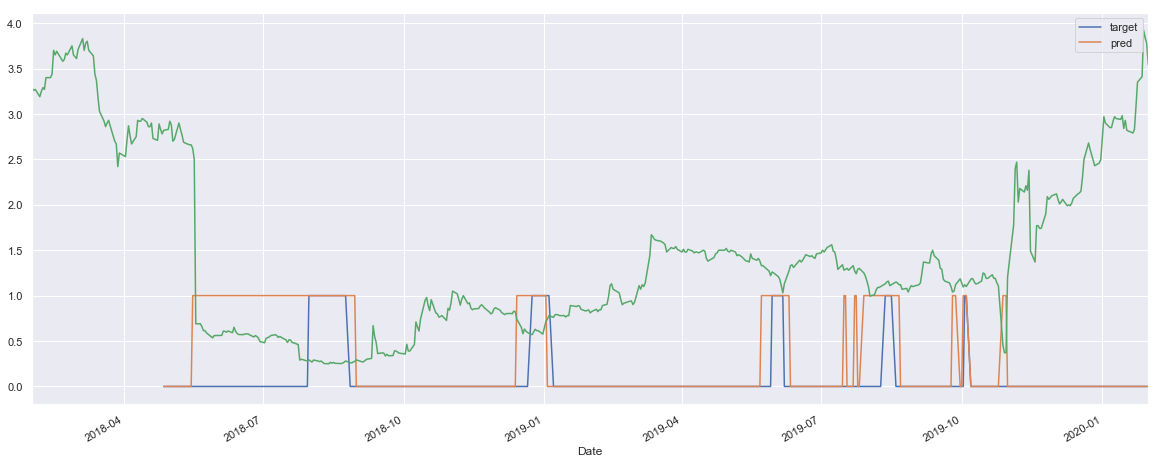

In [20]:
data[[target, 'pred']].plot(figsize=(20,8))
hist.Close.plot()
plt.show()

The predicted labels actually look better than the originally generated labels. 
Let's test the hypothesis that they are less noisy by using this new target to train the scorecard baseline again.

## Data Prep + Scorecard Fidelity Test

In [21]:
hist[target] = data['pred'].fillna(0)
hist[target] = hist[target].fillna(0)

In [22]:
data = hist[['Close', 'Open', 'Low', 'High']]
windows = [3, 5, 10, 15, 20, 30, 45, 60]

for i in windows:
    ma = data.Close.rolling(i).mean()
    data['MACD_'+str(i)] = ma - data.Close
    data['PctDiff_'+str(i)] = data.Close.diff(i)
    data['StdDev_'+str(i)] = data.Close.rolling(i).std()

factor = data.Close.copy()
for c in data.columns.tolist():
    data[c] = data[c] / factor
    
data[target] = hist[target]
data = data.dropna()
del data['Close']

used_cols = [c for c in data.columns.tolist() if c not in [target]]
X, y = data[used_cols].values, data.target.values
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

(0.9927960927960928, 0.006889736742205555)

That's a much healthier looking result!

## Unsupervised HMM (w/ HMMLearn)

In [31]:
X = hist.Close.pct_change(5).dropna().values.reshape(-1,1)

hmm = HMM(n_components=4, random_state=42)
hmm.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=10, params='stmc',
            random_state=42, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=False)

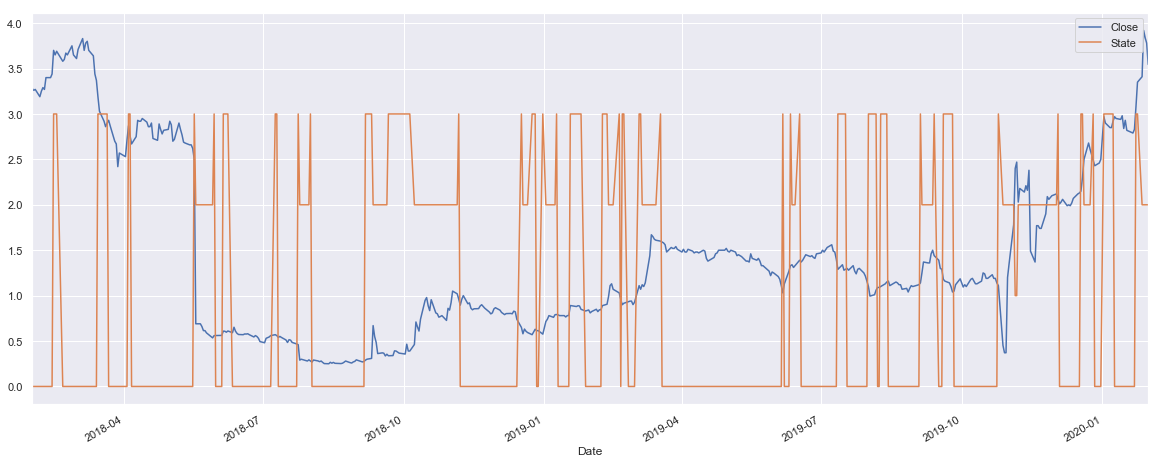

In [32]:
preds = hmm.predict(X)
preds = [0]*5 + preds.tolist()
hist['State'] = preds

hist[['Close', 'State']].plot(figsize=(20,8))
plt.show()

## Further Reading / References

* https://en.wikipedia.org/wiki/Markov_model

* https://en.wikipedia.org/wiki/Hidden_Markov_model

### Time Series Related References

* Cross-Validation for Time-Series: https://robjhyndman.com/hyndsight/tscv/

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

* http://www.zhengwenjie.net/tscv/

* https://alan-turing-institute.github.io/sktime/

### Implementations

* SeqLearn: http://larsmans.github.io/seqlearn/index.html

* HMMLearn: https://hmmlearn.readthedocs.io/en/latest/tutorial.html
